# SS watermark

In [1]:
import librosa
import numpy as np
import scipy
from matplotlib import pyplot as plt

## Watermark Embedding

In [2]:
# read audio data
x, sr = librosa.load("sample.wav",sr=None)
print(sr)
print(x.shape)

22050
(661794,)


In [3]:
# frame segmentation
sig_length = len(x)
frame_length = 4096
hop_length = 4096
overlap = frame_length - hop_length
Nframe = int( (sig_length-overlap) / hop_length)
print(Nframe)

161


In [4]:
# message generation
if_repetitive_coding = True
if if_repetitive_coding:
    repeat = 3
    msg_len = int(Nframe/repeat)
else:
    repeat = 1
    msg_len = Nframe
        
msg = np.random.randint(2, size=msg_len)
print(msg)
print(msg.shape)

[1 1 1 1 0 0 1 1 1 0 0 1 0 1 1 1 1 0 0 1 1 0 0 1 1 1 0 0 0 1 0 0 0 1 0 0 0
 1 0 0 1 1 1 0 1 1 1 0 1 1 1 1 1]
(53,)


In [5]:
# SS sequence
PN_sequence = np.random.rand(frame_length) - 0.5
print(PN_sequence)

[-0.43670639 -0.16531649  0.25818719 ... -0.26302407 -0.3740128
 -0.35410405]


In [6]:
# embed watermark
c = 0.03 # control strength

embedded_x = np.copy(x)
for frame_idx in range(Nframe):
    start = librosa.frames_to_samples(frame_idx,hop_length=hop_length)
    frame = x[start:start+frame_length]
    alpha = c*np.max(np.abs(frame))
    
    if frame_idx//repeat < msg_len:
        msg_bit = int(msg[frame_idx//repeat] * 2 - 1)
    else:
        msg_bit = 0
    
    SS_sequence = msg_bit * PN_sequence
    embedded_x[start:start+hop_length] += SS_sequence


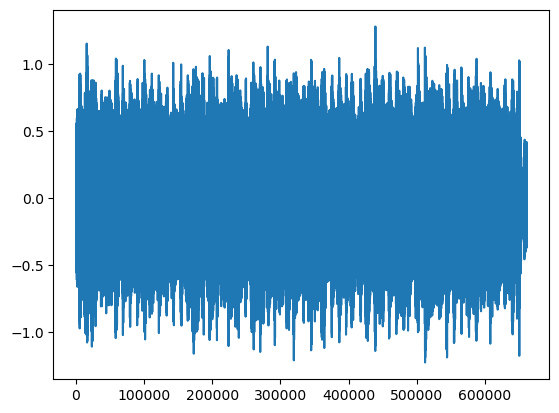

In [7]:
plt.plot(embedded_x)

## Watermark Detection

In [8]:
stream_decode = np.empty(msg.shape)
for frame_idx in range(Nframe):
    start = librosa.frames_to_samples(frame_idx,hop_length=hop_length)
    frame = embedded_x[start:start+frame_length]
    decision = 0
    
    if frame_idx//repeat < msg_len:
        xcorr = scipy.signal.correlate(frame,PN_sequence)
        msg_bit_decode = np.sign(np.min(xcorr)+np.max(xcorr))
        
        decision += msg_bit_decode
        
        if frame_idx%repeat == repeat-1:
            stream_decode[frame_idx//repeat] = 1 if decision>0 else 0
        
    else:
        break

In [9]:
stream_decode

array([1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1.,
       0., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1.,
       1., 1.])

In [10]:
msg

array([1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0,
       0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1])

In [12]:
scipy.signal.correlate

<function scipy.signal.signaltools.correlate(in1, in2, mode='full', method='auto')>